In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from itertools import combinations
from matplotlib.patches import Rectangle

Loading: raw_data\Si-SiGe.dm4
Original shape: (480, 448, 77, 17)
Inferred scan axes (R_axes): (2, 3) shape: (77, 17)
Inferred diffraction axes (Q_axes): (0, 1) shape: (480, 448)
Fixed shape (Rx, Ry, Qx, Qy): (77, 17, 480, 448)
 - Navigation (Real space) = (77, 17)
 - Signal (Reciprocal space) = (480, 448)


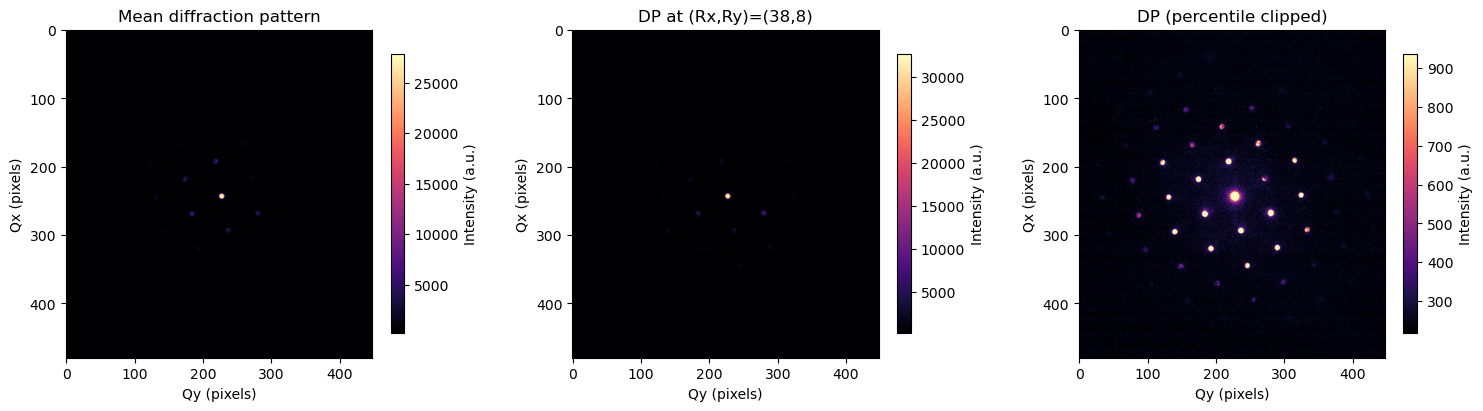

In [10]:
filename = "Si-SiGe.dm4"
if not os.path.exists(filename):
    filename = os.path.join("raw_data", filename)

print("Loading:", filename)
dataset = py4DSTEM.io.import_file(filename)

data_raw = np.asarray(dataset.data)
print("Original shape:", data_raw.shape)

if data_raw.ndim != 4:
    raise ValueError(f"Expected 4D data, but got ndim={data_raw.ndim}, shape={data_raw.shape}")

dims = list(data_raw.shape)

axis_pairs = list(combinations(range(4), 2))
pair_products = [(ax1, ax2, dims[ax1] * dims[ax2]) for ax1, ax2 in axis_pairs]

ax_r1, ax_r2, _ = min(pair_products, key=lambda x: x[2])
R_axes = (ax_r1, ax_r2)

Q_axes = tuple(ax for ax in range(4) if ax not in R_axes)

R_shape = (dims[R_axes[0]], dims[R_axes[1]])
Q_shape = (dims[Q_axes[0]], dims[Q_axes[1]])

print("Inferred scan axes (R_axes):", R_axes, "shape:", R_shape)
print("Inferred diffraction axes (Q_axes):", Q_axes, "shape:", Q_shape)

data_reordered = np.transpose(data_raw, axes=(R_axes[0], R_axes[1], Q_axes[0], Q_axes[1]))

Rx, Ry, Qx, Qy = data_reordered.shape
assert (Rx, Ry) == R_shape, "Scan shape mismatch after transpose."
assert (Qx, Qy) == Q_shape, "Diffraction shape mismatch after transpose."

print("Fixed shape (Rx, Ry, Qx, Qy):", data_reordered.shape)

dataset.data_reordered = data_reordered

print(" - Navigation (Real space) =", (Rx, Ry))
print(" - Signal (Reciprocal space) =", (Qx, Qy))

ix, iy = Rx // 2, Ry // 2
dp = dataset.data_reordered[ix, iy]
dp_mean = dataset.data_reordered.mean(axis=(0, 1))

vmin, vmax = np.percentile(dp, (1, 99.7))

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

im0 = axes[0].imshow(dp_mean, cmap="magma")
axes[0].set_title("Mean diffraction pattern")
axes[0].set_xlabel("Qy (pixels)")
axes[0].set_ylabel("Qx (pixels)")
cbar0 = fig.colorbar(im0, ax=axes[0], shrink=0.85)
cbar0.set_label("Intensity (a.u.)")

im1 = axes[1].imshow(dp, cmap="magma")
axes[1].set_title(f"DP at (Rx,Ry)=({ix},{iy})")
axes[1].set_xlabel("Qy (pixels)")
axes[1].set_ylabel("Qx (pixels)")
cbar1 = fig.colorbar(im1, ax=axes[1], shrink=0.85)
cbar1.set_label("Intensity (a.u.)")

im2 = axes[2].imshow(dp, cmap="magma", vmin=vmin, vmax=vmax)
axes[2].set_title("DP (percentile clipped)")
axes[2].set_xlabel("Qy (pixels)")
axes[2].set_ylabel("Qx (pixels)")
cbar2 = fig.colorbar(im2, ax=axes[2], shrink=0.85)
cbar2.set_label("Intensity (a.u.)")

plt.show()

In [11]:
SCAN_STEP_NM = 2.0  # change if instructor specifies
assert SCAN_STEP_NM > 0, "SCAN_STEP_NM must be positive."

set_ok = False
used_method = None
err_msgs = []

setters = [
    ("dataset.set_scan_step_size(SCAN_STEP_NM)", lambda: dataset.set_scan_step_size(SCAN_STEP_NM)),
    ("dataset.calibration.scan_step_size = SCAN_STEP_NM", lambda: setattr(dataset.calibration, "scan_step_size", SCAN_STEP_NM)),
    ("dataset.R_step_size = SCAN_STEP_NM", lambda: setattr(dataset, "R_step_size", SCAN_STEP_NM)),
]
for name, fn in setters:
    try:
        fn()
        set_ok = True
        used_method = name
        break
    except Exception as e:
        err_msgs.append(f"{name} -> {type(e).__name__}: {e}")

if not hasattr(dataset, "user_metadata"):
    dataset.user_metadata = {}
dataset.user_metadata["scan_step_nm"] = SCAN_STEP_NM

print(f"scan step size = {SCAN_STEP_NM} nm/px")
print(f" - set_ok = {set_ok}")
print(f" - used_method = {used_method}")
if not set_ok:
    print(" - All setters failed. Errors:")
    for m in err_msgs:
        print("   ", m)
    print("\nTip: run `type(dataset)` and `dir(dataset)` to see which calibration fields exist in your py4DSTEM version.")


scan step size = 2.0 nm/px
 - set_ok = True
 - used_method = dataset.calibration.scan_step_size = SCAN_STEP_NM


CoM center (cx, cy) = (225.34, 241.73)


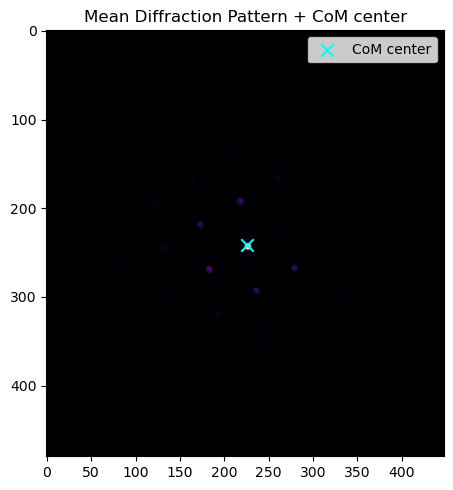

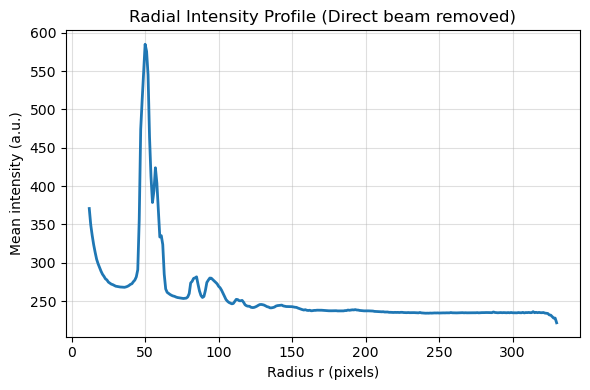

In [12]:
mean_dp = dataset.data_reordered.mean(axis=(0, 1)).astype(np.float64)

ny, nx = mean_dp.shape
yy, xx = np.indices(mean_dp.shape)

cy0, cx0 = ny / 2, nx / 2
r0 = np.sqrt((xx - cx0)**2 + (yy - cy0)**2)

beam_mask = r0 < 40

w = mean_dp * beam_mask
s = w.sum()

cy = float((yy * w).sum() / s)
cx = float((xx * w).sum() / s)

print(f"CoM center (cx, cy) = ({cx:.2f}, {cy:.2f})")

plt.figure(figsize=(6,5))
plt.imshow(mean_dp, cmap="inferno")
plt.scatter(cx, cy, c="cyan", marker="x", s=80, label="CoM center")
plt.title("Mean Diffraction Pattern + CoM center")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Radial intensity profile
# -------------------------
r = np.sqrt((xx - cx)**2 + (yy - cy)**2).astype(np.int32)

r_min = 12  # remove direct beam
r_max = r.max()

radial_sum = np.bincount(r.ravel(), mean_dp.ravel())
radial_cnt = np.bincount(r.ravel())

radial_profile = radial_sum / np.maximum(radial_cnt, 1)
r_values = np.arange(len(radial_profile))

mask = r_values >= r_min

plt.figure(figsize=(6,4))
plt.plot(r_values[mask], radial_profile[mask], lw=2)
plt.xlabel("Radius r (pixels)")
plt.ylabel("Mean intensity (a.u.)")
plt.title("Radial Intensity Profile (Direct beam removed)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

In [13]:
def integrate_virtual_image(data4d, mask2d):
    """
    data4d: (Rx, Ry, Qx, Qy)
    mask2d: (Qx, Qy) float/bool
    return: (Rx, Ry)
    """
    mask = mask2d.astype(np.float64)
    return np.tensordot(data4d, mask, axes=([2, 3], [0, 1]))

def disk_mask(shape, cx, cy, r):
    Qx, Qy = shape
    yy, xx = np.indices((Qx, Qy))
    rr = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    return rr <= r

def annulus_mask(shape, cx, cy, r_in, r_out):
    Qx, Qy = shape
    yy, xx = np.indices((Qx, Qy))
    rr = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    return (rr >= r_in) & (rr <= r_out)

data4d = dataset.data_reordered  # (Rx, Ry, Qx, Qy)
Qx, Qy = data4d.shape[2], data4d.shape[3]

cx0, cy0 = float(cx), float(cy)

r_bf = 20          # BF disk radius
r_adf_in = 70      # ADF inner radius (avoid bright Bragg ring)
r_adf_out = 140    # ADF outer radius

mask_bf = disk_mask((Qx, Qy), cx0, cy0, r_bf)
mask_adf = annulus_mask((Qx, Qy), cx0, cy0, r_adf_in, r_adf_out)

# (optional) safety checks
assert mask_bf.any(), "BF mask is empty—check cx,cy,r_bf"
assert mask_adf.any(), "ADF mask is empty—check r_adf_in/r_adf_out"
assert r_adf_out > r_adf_in > r_bf, "Choose radii: r_adf_out > r_adf_in > r_bf"

bf_image = integrate_virtual_image(data4d, mask_bf)
adf_image = integrate_virtual_image(data4d, mask_adf)

print("BF shape:", bf_image.shape, "ADF shape:", adf_image.shape)
print("BF mask pixels:", mask_bf.sum(), "ADF mask pixels:", mask_adf.sum())

BF shape: (77, 17) ADF shape: (77, 17)
BF mask pixels: 1257 ADF mask pixels: 46183


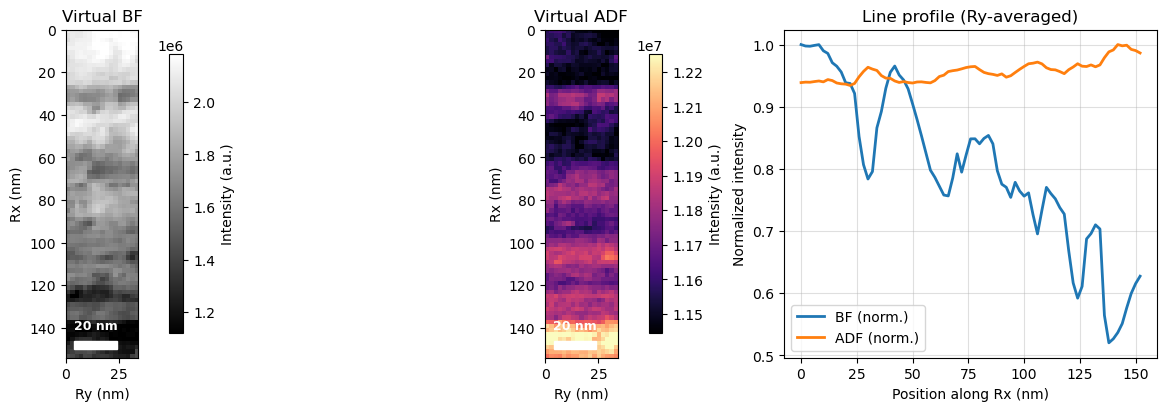

In [14]:
SCAN_STEP_NM = 2.0
SCALE_BAR_NM = 20
CMAP = "magma"

def imshow_percentile(ax, img, cmap=CMAP, p_low=2, p_high=98,
                      scan_step_nm=SCAN_STEP_NM, title=""):
    vmin, vmax = np.percentile(img, (p_low, p_high))

    Rx, Ry = img.shape
    extent = [
        0, Ry * scan_step_nm,      # x axis (Ry) in nm
        Rx * scan_step_nm, 0       # y axis (Rx) in nm (invert so 0 at top)
    ]

    im = ax.imshow(
        img,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=extent
    )

    ax.set_title(title)
    ax.set_xlabel("Ry (nm)")
    ax.set_ylabel("Rx (nm)")
    return im

def add_scale_bar(ax, img_shape, scan_step_nm, bar_nm=SCALE_BAR_NM,
                  pad_px=2, bar_h_px=2, color="white", text_size=9):
    Rx, Ry = img_shape
    bar_px = bar_nm / scan_step_nm

    if bar_px > Ry - 2 * pad_px:
        bar_px = Ry - 2 * pad_px
        bar_nm = bar_px * scan_step_nm

    x0 = pad_px * scan_step_nm
    y0 = Rx * scan_step_nm - (pad_px + bar_h_px) * scan_step_nm

    ax.add_patch(Rectangle(
        (x0, y0),
        bar_px * scan_step_nm,
        bar_h_px * scan_step_nm,
        color=color
    ))
    ax.text(
        x0 + (bar_px * scan_step_nm) / 2,
        y0 - 2 * scan_step_nm,
        f"{bar_nm:.0f} nm",
        color=color,
        ha="center",
        va="bottom",
        fontsize=text_size,
        fontweight="bold"
    )

bf_line = bf_image.mean(axis=1)
adf_line = adf_image.mean(axis=1)

x_nm = np.arange(len(bf_line)) * SCAN_STEP_NM
bf_line_n = bf_line / np.max(bf_line)
adf_line_n = adf_line / np.max(adf_line)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

im1 = imshow_percentile(
    axes[0],
    bf_image,
    cmap="gray",
    scan_step_nm=SCAN_STEP_NM,
    title="Virtual BF"
)
add_scale_bar(axes[0], bf_image.shape, SCAN_STEP_NM)
cbar1 = fig.colorbar(im1, ax=axes[0], shrink=0.85)
cbar1.set_label("Intensity (a.u.)")

im2 = imshow_percentile(
    axes[1],
    adf_image,
    cmap="magma",
    scan_step_nm=SCAN_STEP_NM,
    title="Virtual ADF"
)
add_scale_bar(axes[1], adf_image.shape, SCAN_STEP_NM)
cbar2 = fig.colorbar(im2, ax=axes[1], shrink=0.85)
cbar2.set_label("Intensity (a.u.)")

axes[2].plot(x_nm, bf_line_n, lw=2, label="BF (norm.)")
axes[2].plot(x_nm, adf_line_n, lw=2, label="ADF (norm.)")
axes[2].set_title("Line profile (Ry-averaged)")
axes[2].set_xlabel("Position along Rx (nm)")
axes[2].set_ylabel("Normalized intensity")
axes[2].grid(alpha=0.4)
axes[2].legend()

plt.show()

Estimated interface at Rx index 68 (~ 136.0 nm)


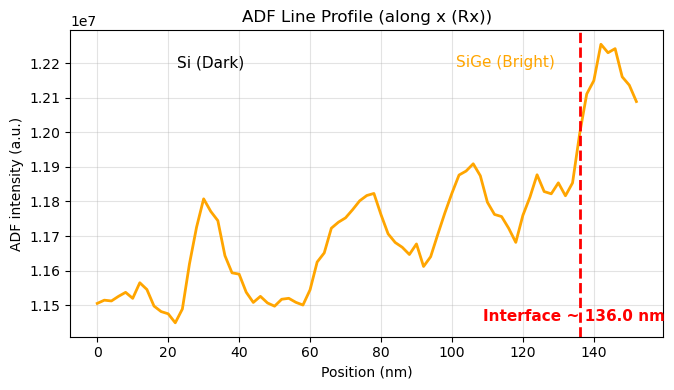

In [15]:
adf_line = adf_image.mean(axis=1)
x_nm = np.arange(len(adf_line)) * SCAN_STEP_NM

w = 7
kernel = np.ones(w) / w
adf_smooth = np.convolve(adf_line, kernel, mode="same")

grad = np.gradient(adf_smooth)
n = len(adf_smooth)
pad = max(3, int(0.10 * n))
grad_roi = grad.copy()
grad_roi[:pad] = 0
grad_roi[-pad:] = 0

ix_interface = int(np.argmax(np.abs(grad_roi)))
x_interface_nm = x_nm[ix_interface]

print(f"Estimated interface at Rx index {ix_interface} (~ {x_interface_nm:.1f} nm)")

plt.figure(figsize=(7,4))
plt.plot(x_nm, adf_line, color="orange", lw=2)
plt.axvline(x_interface_nm, color="red", lw=2, linestyle="--")

plt.title("ADF Line Profile (along x (Rx))")
plt.xlabel("Position (nm)")
plt.ylabel("ADF intensity (a.u.)")
plt.grid(True, alpha=0.35)

ax = plt.gca()

ax.text(0.18, 0.88, "Si (Dark)", transform=ax.transAxes,
        color="black", fontsize=11)

ax.text(0.65, 0.88, "SiGe (Bright)", transform=ax.transAxes,
        color="orange", fontsize=11)
ymin, ymax = ax.get_ylim()
y_text = ymin + 0.05 * (ymax - ymin)
x_text = x_interface_nm - 0.18 * (x_nm.max() - x_nm.min())  # shift left a bit

ax.text(x_text, y_text, f"Interface ~ {x_interface_nm:.1f} nm",
        color="red", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.show()